## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  
from skimage import io
import pickle 


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset

sys.path.insert(0, '../../../Utils')

import models
from train import *
from metrics import *  
from data_downloaders import *

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/home/ljt/cyphercat/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


Python: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]
Pytorch: 1.0.0


## Hyperparameters

In [2]:
n_epochs = 20
batch_size = 48
lr = 0.01
k = 3

target_net_type = models.mlleaks_cnn
shadow_net_type = models.mlleaks_cnn

## Load CIFAR100

Files already downloaded and verified
Files already downloaded and verified


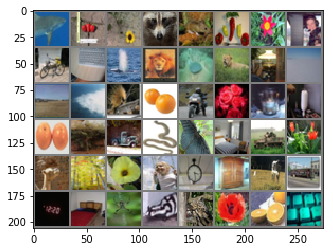

In [3]:
# define series of transforms to pre process images 
train_transform = torchvision.transforms.Compose([  
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
    


# load training set 
cifar100_trainset = torchvision.datasets.CIFAR100('../../../Datasets/', train=True, transform=train_transform, download=True)
cifar100_trainloader = torch.utils.data.DataLoader(cifar100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar100_testset = torchvision.datasets.CIFAR100('../../../Datasets/', train=False, transform=test_transform, download=True)
cifar100_testloader = torch.utils.data.DataLoader(cifar100_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar100_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

## Load LFW

LFW already downloaded.


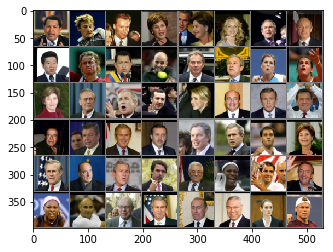

In [4]:
get_lfw('../../../Datasets/')


data_dir = "../../../Datasets/lfw/lfw_20/"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
people_idx = 0 
for i in img_paths: 
    name = i.split('/')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = people_idx
        people_idx += 1


n_lfw_classes = len(people)

img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)

lfw_train_size = int(0.8 * lfw_size)

lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

class LFWDataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        image = io.imread(img_path)
        label = self.people_to_idx[img_path.split('/')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(64),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(64),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
    

lfw_trainset = LFWDataset(lfw_train_list, people_to_idx, transform=train_transform)
lfw_testset = LFWDataset(lfw_test_list, people_to_idx, transform=test_transform)

lfw_trainloader = torch.utils.data.DataLoader(lfw_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
lfw_testloader = torch.utils.data.DataLoader(lfw_testset, batch_size=batch_size, shuffle=False, num_workers=2)


# display sample from dataset 
imgs,labels = iter(lfw_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  


In [5]:
# the model being attacked (architecture can be different than shadow)
target_net = target_net_type(n_out=100).to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


# shadow net mimics the target network (architecture can be different than target)
shadow_net = shadow_net_type(n_out=n_lfw_classes, size=64).to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)


# attack net is a binary classifier to determine membership 

attack_net = models.mlleaks_mlp(n_in=k).to(device)
attack_net.apply(models.weights_init)

attack_loss = nn.BCEWithLogitsLoss()
#attack_loss = nn.BCELoss()
#attack_optim = optim.Adam(attack_net.parameters(), lr=lr)
attack_optim = optim.SGD(attack_net.parameters(), momentum=0.7, nesterov=True,lr=lr)

In [6]:
train(shadow_net, lfw_trainloader, lfw_testloader, shadow_optim, shadow_loss, n_epochs)

[0/20]
Training:

Accuracy = 9.35 %


Test:

Accuracy = 6.12 %


[1/20]
Training:

Accuracy = 21.92 %


Test:

Accuracy = 16.03 %


[2/20]
Training:

Accuracy = 28.04 %


Test:

Accuracy = 18.68 %


[3/20]
Training:

Accuracy = 35.40 %


Test:

Accuracy = 20.83 %


[4/20]
Training:

Accuracy = 38.88 %


Test:

Accuracy = 18.35 %


[5/20]
Training:

Accuracy = 45.41 %


Test:

Accuracy = 24.30 %


[6/20]
Training:

Accuracy = 57.03 %


Test:

Accuracy = 27.60 %


[7/20]
Training:

Accuracy = 67.29 %


Test:

Accuracy = 33.22 %


[8/20]
Training:

Accuracy = 74.90 %


Test:

Accuracy = 34.21 %


[9/20]
Training:

Accuracy = 80.11 %


Test:

Accuracy = 34.55 %


[10/20]
Training:

Accuracy = 85.98 %


Test:

Accuracy = 35.70 %


[11/20]
Training:

Accuracy = 93.34 %


Test:

Accuracy = 38.84 %


[12/20]
Training:

Accuracy = 94.91 %


Test:

Accuracy = 39.67 %


[13/20]
Training:

Accuracy = 97.56 %


Test:

Accuracy = 41.32 %


[14/20]
Training:

Accuracy = 97.85 %


Test:

Accuracy = 41

(98.75930521091811, 41.32231404958678)

In [7]:
train_attacker(attack_net, shadow_net, lfw_trainloader, lfw_testloader, attack_optim, attack_loss, n_epochs=20, k=k)

/home/ljt/cyphercat/venv/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0/20][0/51] loss = 0.75, accuracy = 50.00
[0/20][1/51] loss = 0.74, accuracy = 50.00
[0/20][2/51] loss = 0.73, accuracy = 50.00
[0/20][3/51] loss = 0.72, accuracy = 50.00
[0/20][4/51] loss = 0.72, accuracy = 50.00
[0/20][5/51] loss = 0.71, accuracy = 50.00
[0/20][6/51] loss = 0.71, accuracy = 50.00
[0/20][7/51] loss = 0.70, accuracy = 50.00
[0/20][8/51] loss = 0.70, accuracy = 50.00
[0/20][9/51] loss = 0.70, accuracy = 50.00
[0/20][10/51] loss = 0.69, accuracy = 50.00
[0/20][11/51] loss = 0.69, accuracy = 50.00
[1/20][0/51] loss = 0.69, accuracy = 50.00
[1/20][1/51] loss = 0.69, accuracy = 50.00
[1/20][2/51] loss = 0.69, accuracy = 50.00
[1/20][3/51] loss = 0.69, accuracy = 50.00
[1/20][4/51] loss = 0.69, accuracy = 50.00
[1/20][5/51] loss = 0.69, accuracy = 50.52
[1/20][6/51] loss = 0.69, accuracy = 51.04
[1/20][7/51] loss = 0.69, accuracy = 52.21
[1/20][8/51] loss = 0.69, accuracy = 54.17
[1/20][9/51] loss = 0.69, accuracy = 55.31
[1/20][10/51] loss = 0.69, accuracy = 56.34
[1/20][1

[15/20][10/51] loss = 0.69, accuracy = 72.35
[15/20][11/51] loss = 0.69, accuracy = 72.40
[16/20][0/51] loss = 0.69, accuracy = 67.71
[16/20][1/51] loss = 0.69, accuracy = 68.23
[16/20][2/51] loss = 0.69, accuracy = 71.88
[16/20][3/51] loss = 0.69, accuracy = 70.31
[16/20][4/51] loss = 0.69, accuracy = 70.83
[16/20][5/51] loss = 0.69, accuracy = 72.05
[16/20][6/51] loss = 0.69, accuracy = 72.02
[16/20][7/51] loss = 0.69, accuracy = 71.74
[16/20][8/51] loss = 0.69, accuracy = 72.34
[16/20][9/51] loss = 0.69, accuracy = 71.88
[16/20][10/51] loss = 0.69, accuracy = 71.78
[16/20][11/51] loss = 0.69, accuracy = 71.96
[17/20][0/51] loss = 0.69, accuracy = 71.88
[17/20][1/51] loss = 0.69, accuracy = 69.79
[17/20][2/51] loss = 0.69, accuracy = 72.22
[17/20][3/51] loss = 0.69, accuracy = 71.09
[17/20][4/51] loss = 0.68, accuracy = 71.67
[17/20][5/51] loss = 0.68, accuracy = 73.44
[17/20][6/51] loss = 0.69, accuracy = 73.07
[17/20][7/51] loss = 0.69, accuracy = 72.66
[17/20][8/51] loss = 0.69, a

In [8]:
train(target_net, cifar100_trainloader, cifar100_testloader, target_optim, target_loss, n_epochs)

[0/20]
Training:

Accuracy = 21.27 %


Test:

Accuracy = 19.91 %


[1/20]
Training:

Accuracy = 31.22 %


Test:

Accuracy = 27.18 %


[2/20]
Training:

Accuracy = 38.10 %


Test:

Accuracy = 29.98 %


[3/20]
Training:

Accuracy = 41.83 %


Test:

Accuracy = 31.70 %


[4/20]
Training:

Accuracy = 43.29 %


Test:

Accuracy = 30.49 %


[5/20]
Training:

Accuracy = 45.95 %


Test:

Accuracy = 30.65 %


[6/20]
Training:

Accuracy = 49.26 %


Test:

Accuracy = 32.10 %


[7/20]
Training:

Accuracy = 50.67 %


Test:

Accuracy = 31.00 %


[8/20]
Training:

Accuracy = 54.14 %


Test:

Accuracy = 31.51 %


[9/20]
Training:

Accuracy = 59.01 %


Test:

Accuracy = 32.24 %


[10/20]
Training:

Accuracy = 56.04 %


Test:

Accuracy = 30.49 %


[11/20]
Training:

Accuracy = 59.94 %


Test:

Accuracy = 31.24 %


[12/20]
Training:

Accuracy = 58.77 %


Test:

Accuracy = 30.40 %


[13/20]
Training:

Accuracy = 59.86 %


Test:

Accuracy = 29.57 %


[14/20]
Training:

Accuracy = 59.47 %


Test:

Accuracy = 

(65.056, 29.270000000000003)

In [9]:
train_accuracy = eval_target_net(target_net, cifar100_trainloader)
test_accuracy = eval_target_net(target_net, cifar100_testloader)

print("Target Network Classification Performance")
print("Train Accuracy = %.2f%%, Test Accuracy = %.2f%%" % (train_accuracy, test_accuracy))


Accuracy = 65.06 %



Accuracy = 29.27 %


Target Network Classification Performance
Train Accuracy = 65.06%, Test Accuracy = 29.27%


Membership Inference Performance
Accuracy = 55.10%, Precision = 0.59, Recall = 0.35


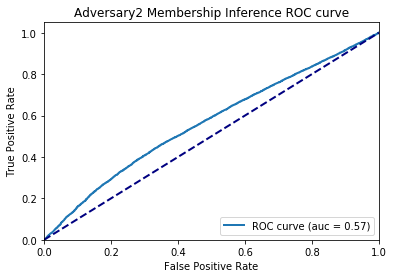

In [10]:
fpr, tpr, roc_auc = eval_attack_roc(attack_net, target_net, cifar100_trainloader, cifar100_testloader, k)
#eval_attack_net(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, k)

lw = 2
plt.figure()
plt.plot(fpr, tpr, lw=lw, 
         label='ROC curve (auc = %.2f)' % (roc_auc))
plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.title('Adversary2 Membership Inference ROC curve')
plt.legend(loc="lower right")
plt.show()


results = (fpr, tpr, roc_auc)
pickle.dump(results, open("adv2_cifar100_lfw_results", "wb"))

## Results

Target Network Classification Performance
Train Accuracy = 85.03%, Test Accuracy = 28.12%

Membership Inference Performance
Accuracy = 58.64%, Precision = 0.56, Recall = 0.81

| Dataset         |Train Accuracy | Test Accuracy | Attack AUC | Attack Accuracy | Attack Precision | Attack Recall |
| ----------------|---------------| --------------|------------|-----------------|------------------|---------------|
| CIFAR-10        | 96.05 %       | 60.55 %       | 0.68       | 60.28 %         | 57 %             | 87 %          |
| CIFAR-100       | 93.78 %       | 21.31 %       | 0.77       | 68.31 %         | 64 %             | 85 %          |
| LFW             | 100.00 %      | 33.72 %       | 0.80       | 63.72 %         | 58 %             | 100 %         |
|Adv2(CIFAR100/LFW)| 85.03 %      | 28.12 %       | 0.65       | 58.64 %         | 56 %             | 81 %          |

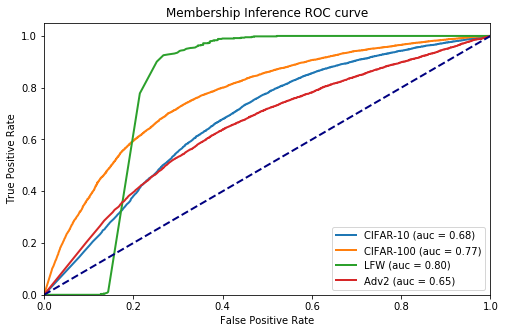